# Chapter 4 - Train A Deeper Fully Connected Neural Network

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential

Set the random seed to 2 so you always see similar results:

In [2]:
import random
random.seed(2)

import tensorflow as tf
tf.random.set_seed(2)

import numpy as np
np.random.seed(2)

### Your Task

Your fame meets no bounds at Worldwide Pizza Co.! Teams from around the world reach out for your help. You have received traffic data from one of the restaurant teams. They want to automatically increase delivery times if an order is placed during heavy traffic times.

They asked you to help out and sent you a dataset they recorded with the day, hour, minute, and second their driver recorded as well whether there was any traffic.

Using this data, you will have to build a classifier that predicts traffic.

### Understand the data

In [3]:
traffic_data = pd.read_csv('datasets/traffic_data.csv', index_col=0)

In [4]:
traffic_data.head()

,day,minute,hour,second,type
0,Monday,0,8,14,traffic
1,Monday,0,8,28,traffic
2,Monday,0,8,34,traffic
3,Monday,0,8,45,traffic
4,Monday,0,8,53,traffic


In [5]:
traffic_data.shape

(85638, 5)

There is a ton of data here! Great! Let's understand the traffic vs non-traffic variable:

In [6]:
traffic_data['type'].value_counts()

type
no_traffic    50769
traffic       34869
Name: count, dtype: int64

The dataset is imbalanced, there is more data when there is no traffic, but you will manage!

In [7]:
traffic_data['day'].value_counts()

day
Sunday       12278
Saturday     12251
Thursday     12241
Wednesday    12237
Tuesday      12217
Monday       12212
Friday       12202
Name: count, dtype: int64

There is a relatively equal representation of data every day. How about the traffic vs. non-traffic variable per day?

In [8]:
traffic_data.groupby('day')['type'].value_counts()

day        type      
Friday     traffic        6989
           no_traffic     5213
Monday     traffic        6972
           no_traffic     5240
Saturday   no_traffic    12251
Sunday     no_traffic    12278
Thursday   traffic        6965
           no_traffic     5276
Tuesday    traffic        6990
           no_traffic     5227
Wednesday  traffic        6953
           no_traffic     5284
Name: count, dtype: int64

Fairly equal traffic vs no-traffic representations outside of Saturdays and Sundays. What about per hour?

In [9]:
traffic_data['hour'].value_counts()

hour
8     6211
16    6204
20    6195
18    6188
14    6180
10    6156
12    6147
15    6110
17    6076
13    6052
21    6046
11    6046
19    6036
9     5988
22       3
Name: count, dtype: int64

Hours start at 8 and stop at 22. 22 has very little data.

Set up the type as a number:

In [10]:
traffic_data['c_type'] = traffic_data['type'].apply(lambda x: 1 if x == 'traffic' else 0)

It's quite hard to visualize the data. Nonetheless, let's try to plot days, hours, and type:

In [11]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import colorbar, figure

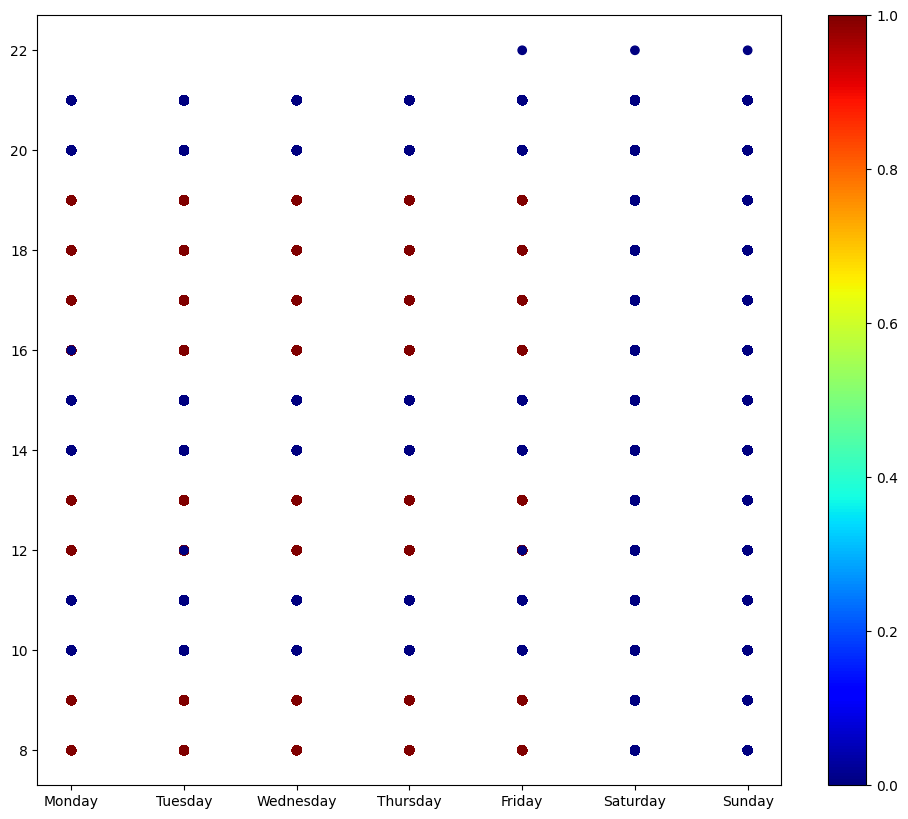

In [12]:
figure(num=None, figsize=(12, 10))
plt.scatter(
    traffic_data['day'], 
    traffic_data['hour'], 
    c=traffic_data['c_type'], 
    cmap='jet',
)
cbar = colorbar()

As seen before, there is no traffic on Saturdays or Sundays. It seems to be mostly around some key hours, such as 8-10, 12-13, and 16-20.

Let's first convert the days to new columns using one-hot encoding:

In [13]:
traffic_data = traffic_data.join(pd.get_dummies(traffic_data['day']))

Split the data again into a training and test set:

In [14]:
training_dataset = traffic_data.sample(frac=0.8)
testing_dataset = traffic_data[~traffic_data.index.isin(training_dataset.index)]

And select the input columns you will be using from this dataset:

In [15]:
input_columns = [
    'Monday', 
    'Tuesday', 
    'Wednesday', 
    'Thursday', 
    'Friday', 
    'Saturday', 
    'Sunday', 
    'hour', 
    'minute', 
    'second'
]

### Set Up Your First Neural Network With a Hidden Layer

In [16]:
from tensorflow.keras.layers import Dropout

In [17]:
traffic_model = Sequential([
    Dense(32, input_dim=len(input_columns), activation='relu'),
    Dropout(0.1),
    Dense(32, activation='relu'),
    Dropout(0.1),
    Dense(1, activation='sigmoid'),
])

adam = Adam()

traffic_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
traffic_model.summary()

c:\Users\yoann\Documents\Projet AI\introduction-to-deep-learning\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,441 (5.63 KB)

 Trainable params: 1,441 (5.63 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
batch_size = 100

In [19]:
history_traffic_model = traffic_model.fit(
    training_dataset[input_columns], 
    training_dataset[['c_type']], 
    epochs=30,
    validation_split=0.1,
    batch_size=batch_size
)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type bool).

In [ ]:
test_loss, test_acc = traffic_model.evaluate(
    testing_dataset[input_columns], 
    testing_dataset['c_type']
)

print(f"Evaluation result on Test Data : Loss = {test_loss}, accuracy = {test_acc}")

536/536 [==============================] - 1s 2ms/step - loss: 0.0765 - accuracy: 0.9984
Evaluation result on Test Data : Loss = 0.0765421986579895, accuracy = 0.9983652234077454


The restaurant team is thrilled with your results!

That’s awesome! You just built your first deep neural network and trained it to a high accuracy. Congratulations!